In [23]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

### Load data

In [24]:
df = pd.read_csv("../data/clean/main_df.csv")

### Turn string values into numerical ones

In [25]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})
df.drop(['current_year_rank'], axis=1, inplace=True)

def map_strings_to_int(df, col):
    """
    Maps string values to integers
    """
    values = df[col].unique()
    mapping = {value: i for i, value in enumerate(values)}
    df[col] = df[col].map(mapping)

map_strings_to_int(df, "tmID")
# map_strings_to_int(df, "playerID")
# map_strings_to_int(df, "coachID")
# map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

# print(df['tmID'].to_frame())

### Training and evaluation function

In [26]:
from dataclasses import dataclass

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = {}

def classification(model, df, min_year, max_year):
    for i in range(min_year, max_year + 1):
        df_train = df[df['year'] < i]
        df_test = df[df['year'] == i]

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=roc_auc_score(y_test, y_pred),
        )

        if (str(model) not in results):
            results[str(model)] = []
        results[str(model)].append(result)

### Define values for min_year and max_year

In [27]:
min_year = 2
max_year = df['year'].max()

### Decision Tree


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.50      0.75      0.60         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.47        16
weighted avg       0.50      0.50      0.47        16


year = 2, Confusion Matrix:
 [[2 6]
 [2 6]]

year = 2, AUC:  0.5

year = 2, Accuracy:  0.5

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16


year = 3, Confusion Matrix:
 [[6 2]
 [2 6]]

year = 3, AUC:  0.75

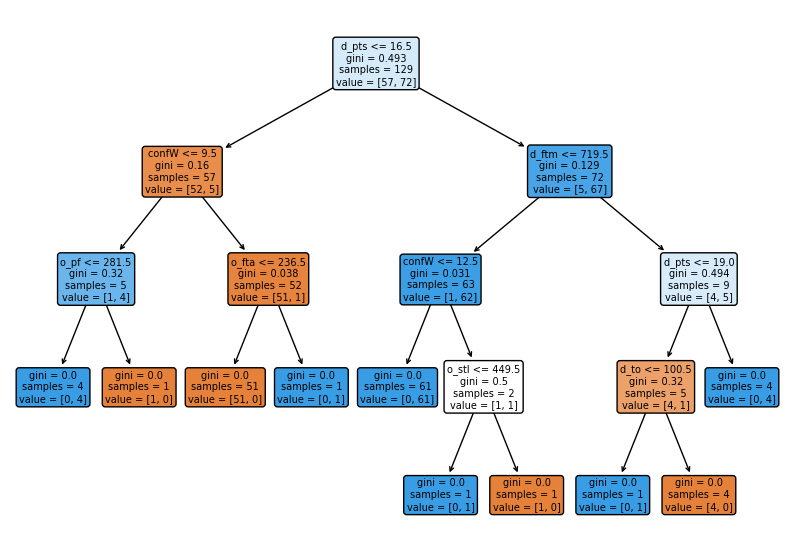

In [28]:
model = DecisionTreeClassifier(random_state=42)
classification(model, df, min_year, max_year)

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [29]:
model = SVC(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16


year = 2, Confusion Matrix:
 [[7 1]
 [1 7]]

year = 2, AUC:  0.875

year = 2, Accuracy:  0.875

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16


year = 3, Confusion Matrix:
 [[7 1]
 [1 7]]

year = 3, AUC:  

### Logistic Regression

In [30]:
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16


year = 2, Confusion Matrix:
 [[6 2]
 [0 8]]

year = 2, AUC:  0.875

year = 2, Accuracy:  0.875

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16


year = 3, Confusion Matrix:
 [[7 1]
 [3 5]]

year = 3, AUC:  

### Random Forest

In [31]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


year = 2, Confusion Matrix:
 [[8 0]
 [1 7]]

year = 2, AUC:  0.9375

year = 2, Accuracy:  0.9375

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


year = 3, Confusion Matrix:
 [[7 1]
 [0 8]]

year = 3, AUC:

### Gradient Boosting Classifier

In [32]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


year = 2, Confusion Matrix:
 [[8 0]
 [1 7]]

year = 2, AUC:  0.9375

year = 2, Accuracy:  0.9375

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16


year = 3, Confusion Matrix:
 [[6 2]
 [2 6]]

year = 3, AUC:

### K Neighbors

In [33]:
model = KNeighborsClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=2: (16, 53) (16, 53) (16,) (16,)

year = 2, Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


year = 2, Confusion Matrix:
 [[2 6]
 [0 8]]

year = 2, AUC:  0.625

year = 2, Accuracy:  0.625

Train/Test size for year=3: (32, 53) (16, 53) (32,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16


year = 3, Confusion Matrix:
 [[7 1]
 [3 5]]

year = 3, AUC:  

# Results

In [34]:
from pprint import pprint

# Extracting accuracy for the last year for each model
previous_year_accuracies = {model: results[model][-1].accuracy for model in results}

# Sorting the results by accuracy in descending order
sorted_results = dict(sorted(previous_year_accuracies.items(), key=lambda item: item[1], reverse=True))

# Printing the results
print("Train/test results for the last year of data:\n")
for model, accuracy in sorted_results.items():
    print(f"{model}: {accuracy:.4f}")

for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

Train/test results for the last year of data:

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'): 0.8462
RandomForestClassifier(random_state=42): 0.8462
GradientBoostingClassifier(): 0.8462
DecisionTreeClassifier(random_state=42): 0.6154
SVC(random_state=42): 0.6154
KNeighborsClassifier(): 0.6154
